## In this notebook we create our model and evaluate it

**Model Steps:**

1. Run PCA on the preprocessed data

2. Use the elbow method to find a k value

3. Run kmeans with the dataframe created in the PCA step



# Set up and load data

In [1]:
# !pip install --quiet pyarrow polars

In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from umap import UMAP

RANDOM_STATE = 42

# if local
processed_users_path = "data/users_cleaned_df_encoded.parquet"
songs_path = "data/songs_df_full.csv"

In [4]:
# processed_users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df_encoded.parquet"
# songs_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/songs_df_full.csv"
# from google.colab import drive
#
# drive.mount('/content/drive')

In [5]:
# Polars is faster at loading large datasets
users_polars_df = pl.read_parquet(processed_users_path)

In [6]:
# This conversion can take 51s on regular ram, 21 seconds on high ram mode
users_df_orig = users_polars_df.to_pandas(use_pyarrow_extension_array=True)

In [10]:
len(users_df_orig)

574660

In [8]:
users_df = users_df_orig.copy().sample(
    n=100000,
    random_state=RANDOM_STATE
)

In [9]:
# Drop all one hot encoded fav artist columns (takes too long to run)
users_df = users_df[users_df.columns.drop(list(users_df.filter(regex='fav_artist_')))]
len(users_df)

100000

In [ ]:
# Load the songs data to use it in the playlist generation at the end
# songs_df = pd.read_csv(songs_path)
# len(songs_df)

## Dimensional Reduction

### PCA for k-means
Run PCA and capture at least 90% of the variance.

In [11]:
# Want to keep at least 90% of the variance
transformer = PCA(n_components=0.9, random_state=RANDOM_STATE)

In [12]:
# Drop user_id as it will not have relevance for clustering
X = users_df.drop(columns=['user_id'])

In [13]:
X_pca = transformer.fit_transform(X)

In [14]:
# Create new columns for each of the components
num_cols = X_pca.shape[1]
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i + 1}' for i in range(num_cols)]
)
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,4.590005,1.437688,-0.625336,1.068352,-1.751549,-0.657102,0.098903,-0.502036
1,1.976152,0.638498,0.195235,-0.725067,-0.308644,-1.585062,0.328578,0.607848
2,-1.925697,0.112705,0.371015,0.143592,0.155785,0.447106,0.111761,-0.421562
3,0.854543,-1.652101,-0.048210,0.855743,-0.557086,-0.151236,-0.384393,0.161674
4,-2.075723,-0.597488,0.837692,-0.731763,0.319027,0.529576,0.333888,-0.047775


In [15]:
print("Explained variance ratio by each component:", transformer.explained_variance_ratio_)
print("Total variance captured:", np.sum(transformer.explained_variance_ratio_))

Explained variance ratio by each component: [0.38678084 0.25348013 0.08383414 0.07222321 0.06250726 0.02053339
 0.01827797 0.01546313]
Total variance captured: 0.9131000659815949


### UMAP for HDBSCAN

In [ ]:
# todo: move

# Model Creation & Evaluation

## Model 1: K Means

### Picking K: Elbow method
Use elbow method and a plot to see how many clusters we should use.

In [16]:
n_clusters = 30  # how many clusters to test
k_values = range(1, n_clusters + 1)
inertia_values = []
# store the number of data points within each cluster for every k tested
kmeans_comp_arr = np.zeros((n_clusters, n_clusters))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    kmeans_fitted = kmeans.fit(X_pca_df)
    inertia_values.append(kmeans.inertia_)
    # unique cluster labels assigned to each data point, counts points in cluster
    cluster_id, counts = np.unique(kmeans_fitted.labels_, return_counts=True)
    for i in range(len(cluster_id)):
        kmeans_comp_arr[k - 1, cluster_id[i]] = counts[i]

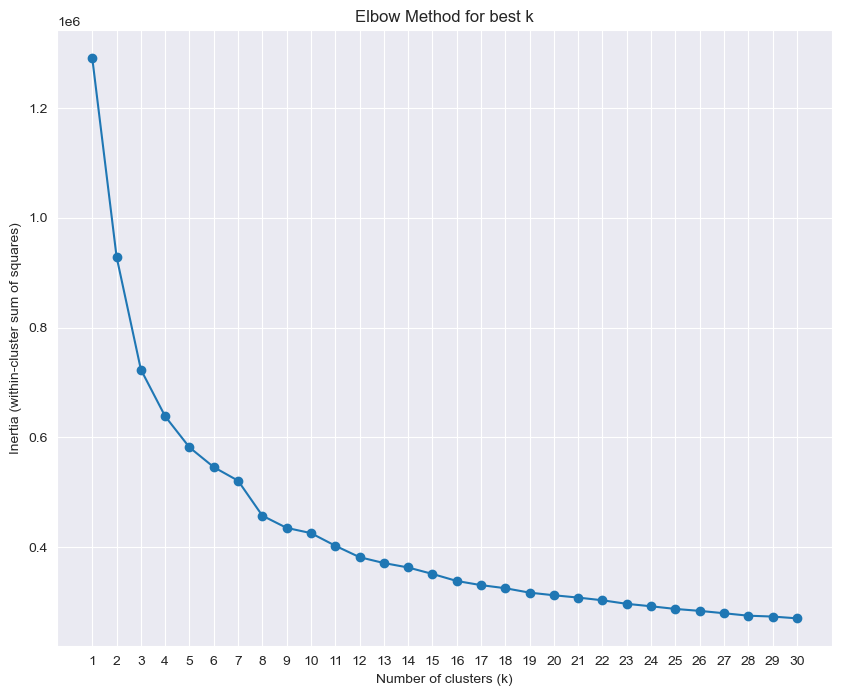

In [17]:
# Plot the elbow
plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia_values, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for best k')
plt.grid(True)
plt.show()

In [18]:
kmeans_comp_df = pd.DataFrame(
    kmeans_comp_arr,
    index=k_values,
    columns=[f'Cluster {i}' for i in range(n_clusters)]
)

print("Distribution of data points per cluster for each k (rows = k, columns = cluster ID):")
display(kmeans_comp_df.head(10))

Distribution of data points per cluster for each k (rows = k, columns = cluster ID):


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 20,Cluster 21,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27,Cluster 28,Cluster 29
1,100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,77105.0,22895.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73254.0,15997.0,10749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,61533.0,23176.0,6539.0,8752.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,57706.0,14481.0,19502.0,2457.0,5854.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,48119.0,21792.0,10815.0,2351.0,3196.0,13727.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,45834.0,1794.0,10961.0,2345.0,2894.0,13513.0,22659.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,38062.0,17729.0,2883.0,2064.0,9482.0,11572.0,10240.0,7968.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,35091.0,15772.0,2896.0,1230.0,9263.0,5983.0,9158.0,7708.0,12899.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,32104.0,16763.0,2460.0,2126.0,7577.0,5172.0,9073.0,3828.0,10654.0,10243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


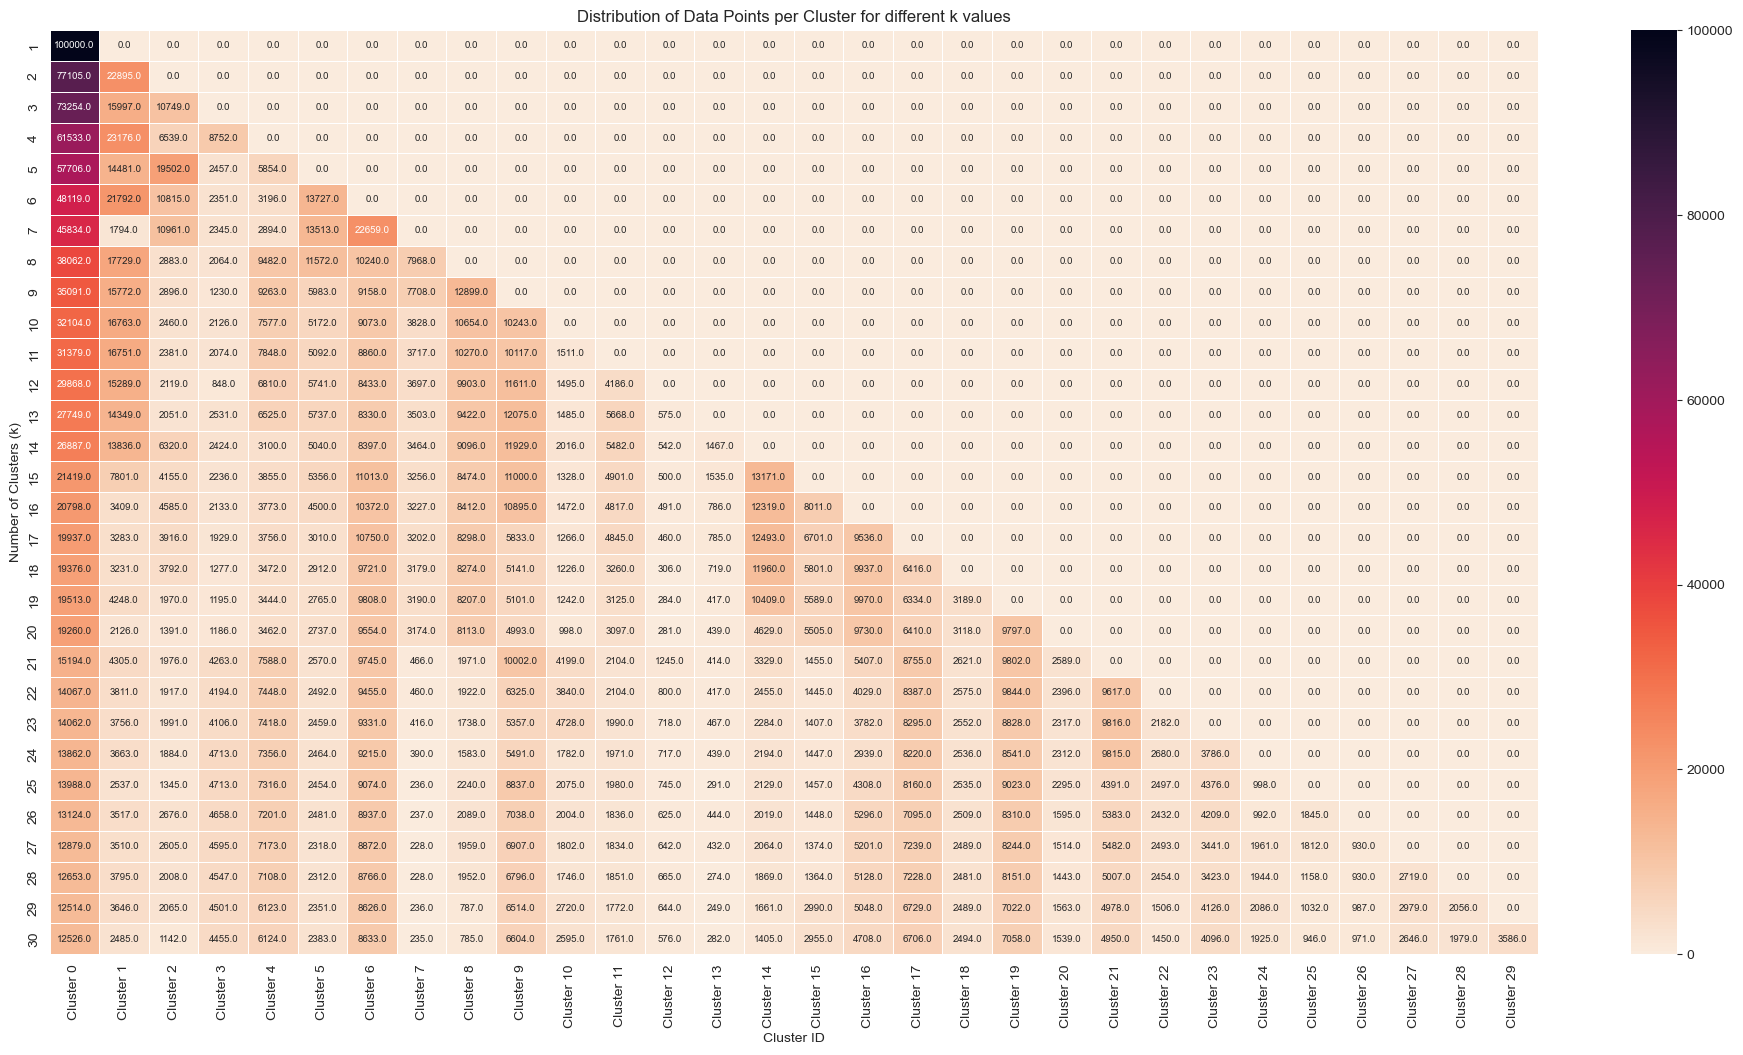

In [19]:
plt.figure(figsize=(24, 12))
sns.heatmap(kmeans_comp_df,
            annot=True,
            fmt='.1f',
            cmap='rocket_r',
            annot_kws={'fontsize': 7},
            linewidths=0.5
            )
plt.title('Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

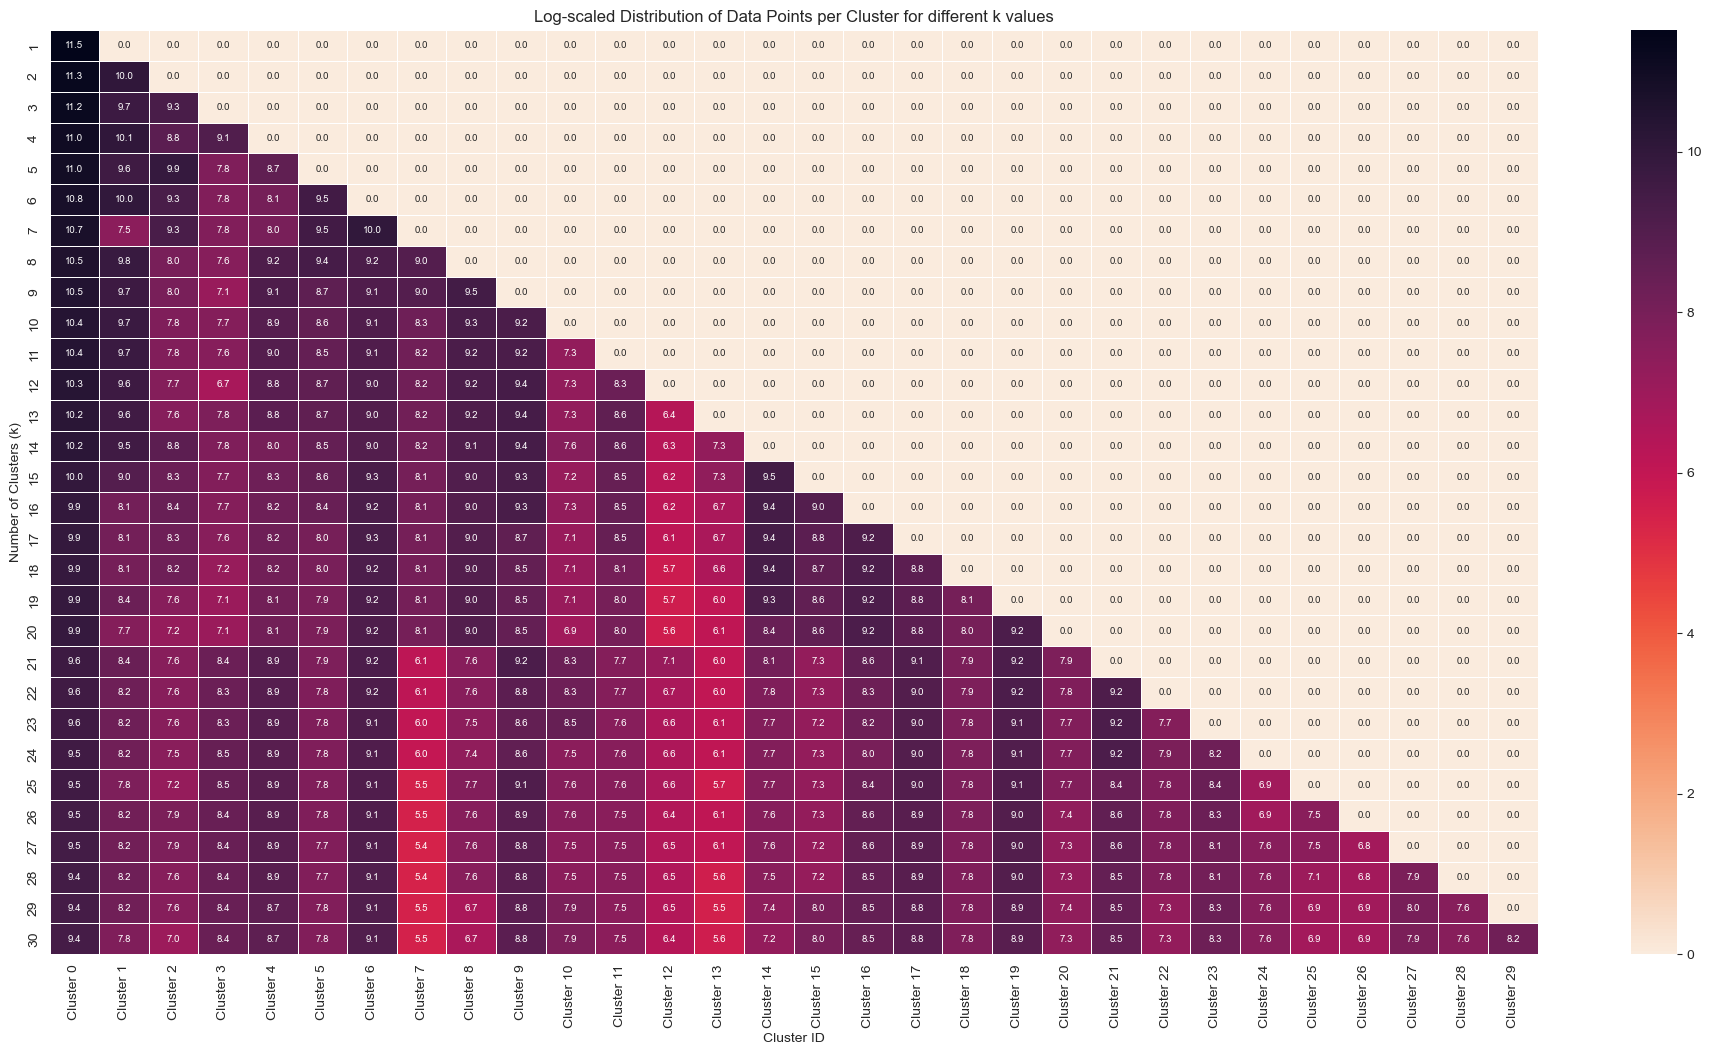

In [20]:
plt.figure(figsize=(24, 12))
sns.heatmap(np.log1p(kmeans_comp_df), annot=True, fmt='.1f', cmap='rocket_r', annot_kws={'fontsize': 7}, linewidths=0.5)
plt.title('Log-scaled Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

### Run k-means

In [32]:
# Based on the elbow, we observe a leveling out at k=9
k_num_clusters = 26

In [33]:
kmeans = KMeans(n_clusters=k_num_clusters, random_state=RANDOM_STATE, n_init='auto')
kmeans_fitted = kmeans.fit(X_pca_df)
inertia_values.append(kmeans.inertia_)
np.unique(kmeans_fitted.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
 array([13124,  3517,  2676,  4658,  7201,  2481,  8937,   237,  2089,
         7038,  2004,  1836,   625,   444,  2019,  1448,  5296,  7095,
         2509,  8310,  1595,  5383,  2432,  4209,   992,  1845]))

In [34]:
# Compute Silhouette Score to measure cluster similarity
# It's costly to run so we sample with 100k
sample = np.random.choice(len(X_pca_df), size=100000, replace=False)
score = silhouette_score(X_pca_df.iloc[sample], kmeans_fitted.labels_[sample])
print("Silhouette Score (sample):", score)

Silhouette Score (sample): 0.13884709496868597


In [43]:
# For PCA Plots
users_columns_pca = X_pca_df.columns
users_centroids_pca = kmeans_fitted.cluster_centers_
users_kmeans_centroids_df = pd.DataFrame(columns=users_columns_pca, data=users_centroids_pca)
users_kmeans_centroids_df['kmeans_cluster'] = users_kmeans_centroids_df.index

users_df_kmeans_clusters = X_pca_df.copy()
users_df_kmeans_clusters['kmeans_cluster'] = kmeans_fitted.labels_
users_df_kmeans_clusters['user_id'] = users_df['user_id']

In [44]:
users_kmeans_centroids_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,kmeans_cluster
0,-1.751618,-0.685814,0.520122,-0.349567,0.083565,0.333117,0.235298,-0.052684,0
1,0.446308,-1.180464,0.048108,0.121638,1.698863,0.080389,-0.094038,-0.070496,1
2,3.869813,-1.667796,0.173305,-0.190753,-1.051045,0.227538,-0.174873,0.117941,2
3,1.114035,0.852368,0.349806,-0.472397,-0.195646,-0.445542,0.401944,-0.141247,3
4,-1.818003,-0.536991,-1.340218,-0.276717,-0.109033,0.016221,-0.050172,0.024217,4


In [45]:
# For visualizing using original features
users_df_clusters_orig = users_df.copy()
users_df_clusters_orig['kmeans_cluster'] = kmeans_fitted.labels_
users_df_clusters_orig['user_id'] = users_df['user_id']

In [46]:
users_df_kmeans_clusters['kmeans_cluster'].value_counts().sort_index()

kmeans_cluster
0     13124
1      3517
2      2676
3      4658
4      7201
5      2481
6      8937
7       237
8      2089
9      7038
10     2004
11     1836
12      625
13      444
14     2019
15     1448
16     5296
17     7095
18     2509
19     8310
20     1595
21     5383
22     2432
23     4209
24      992
25     1845
Name: count, dtype: int64

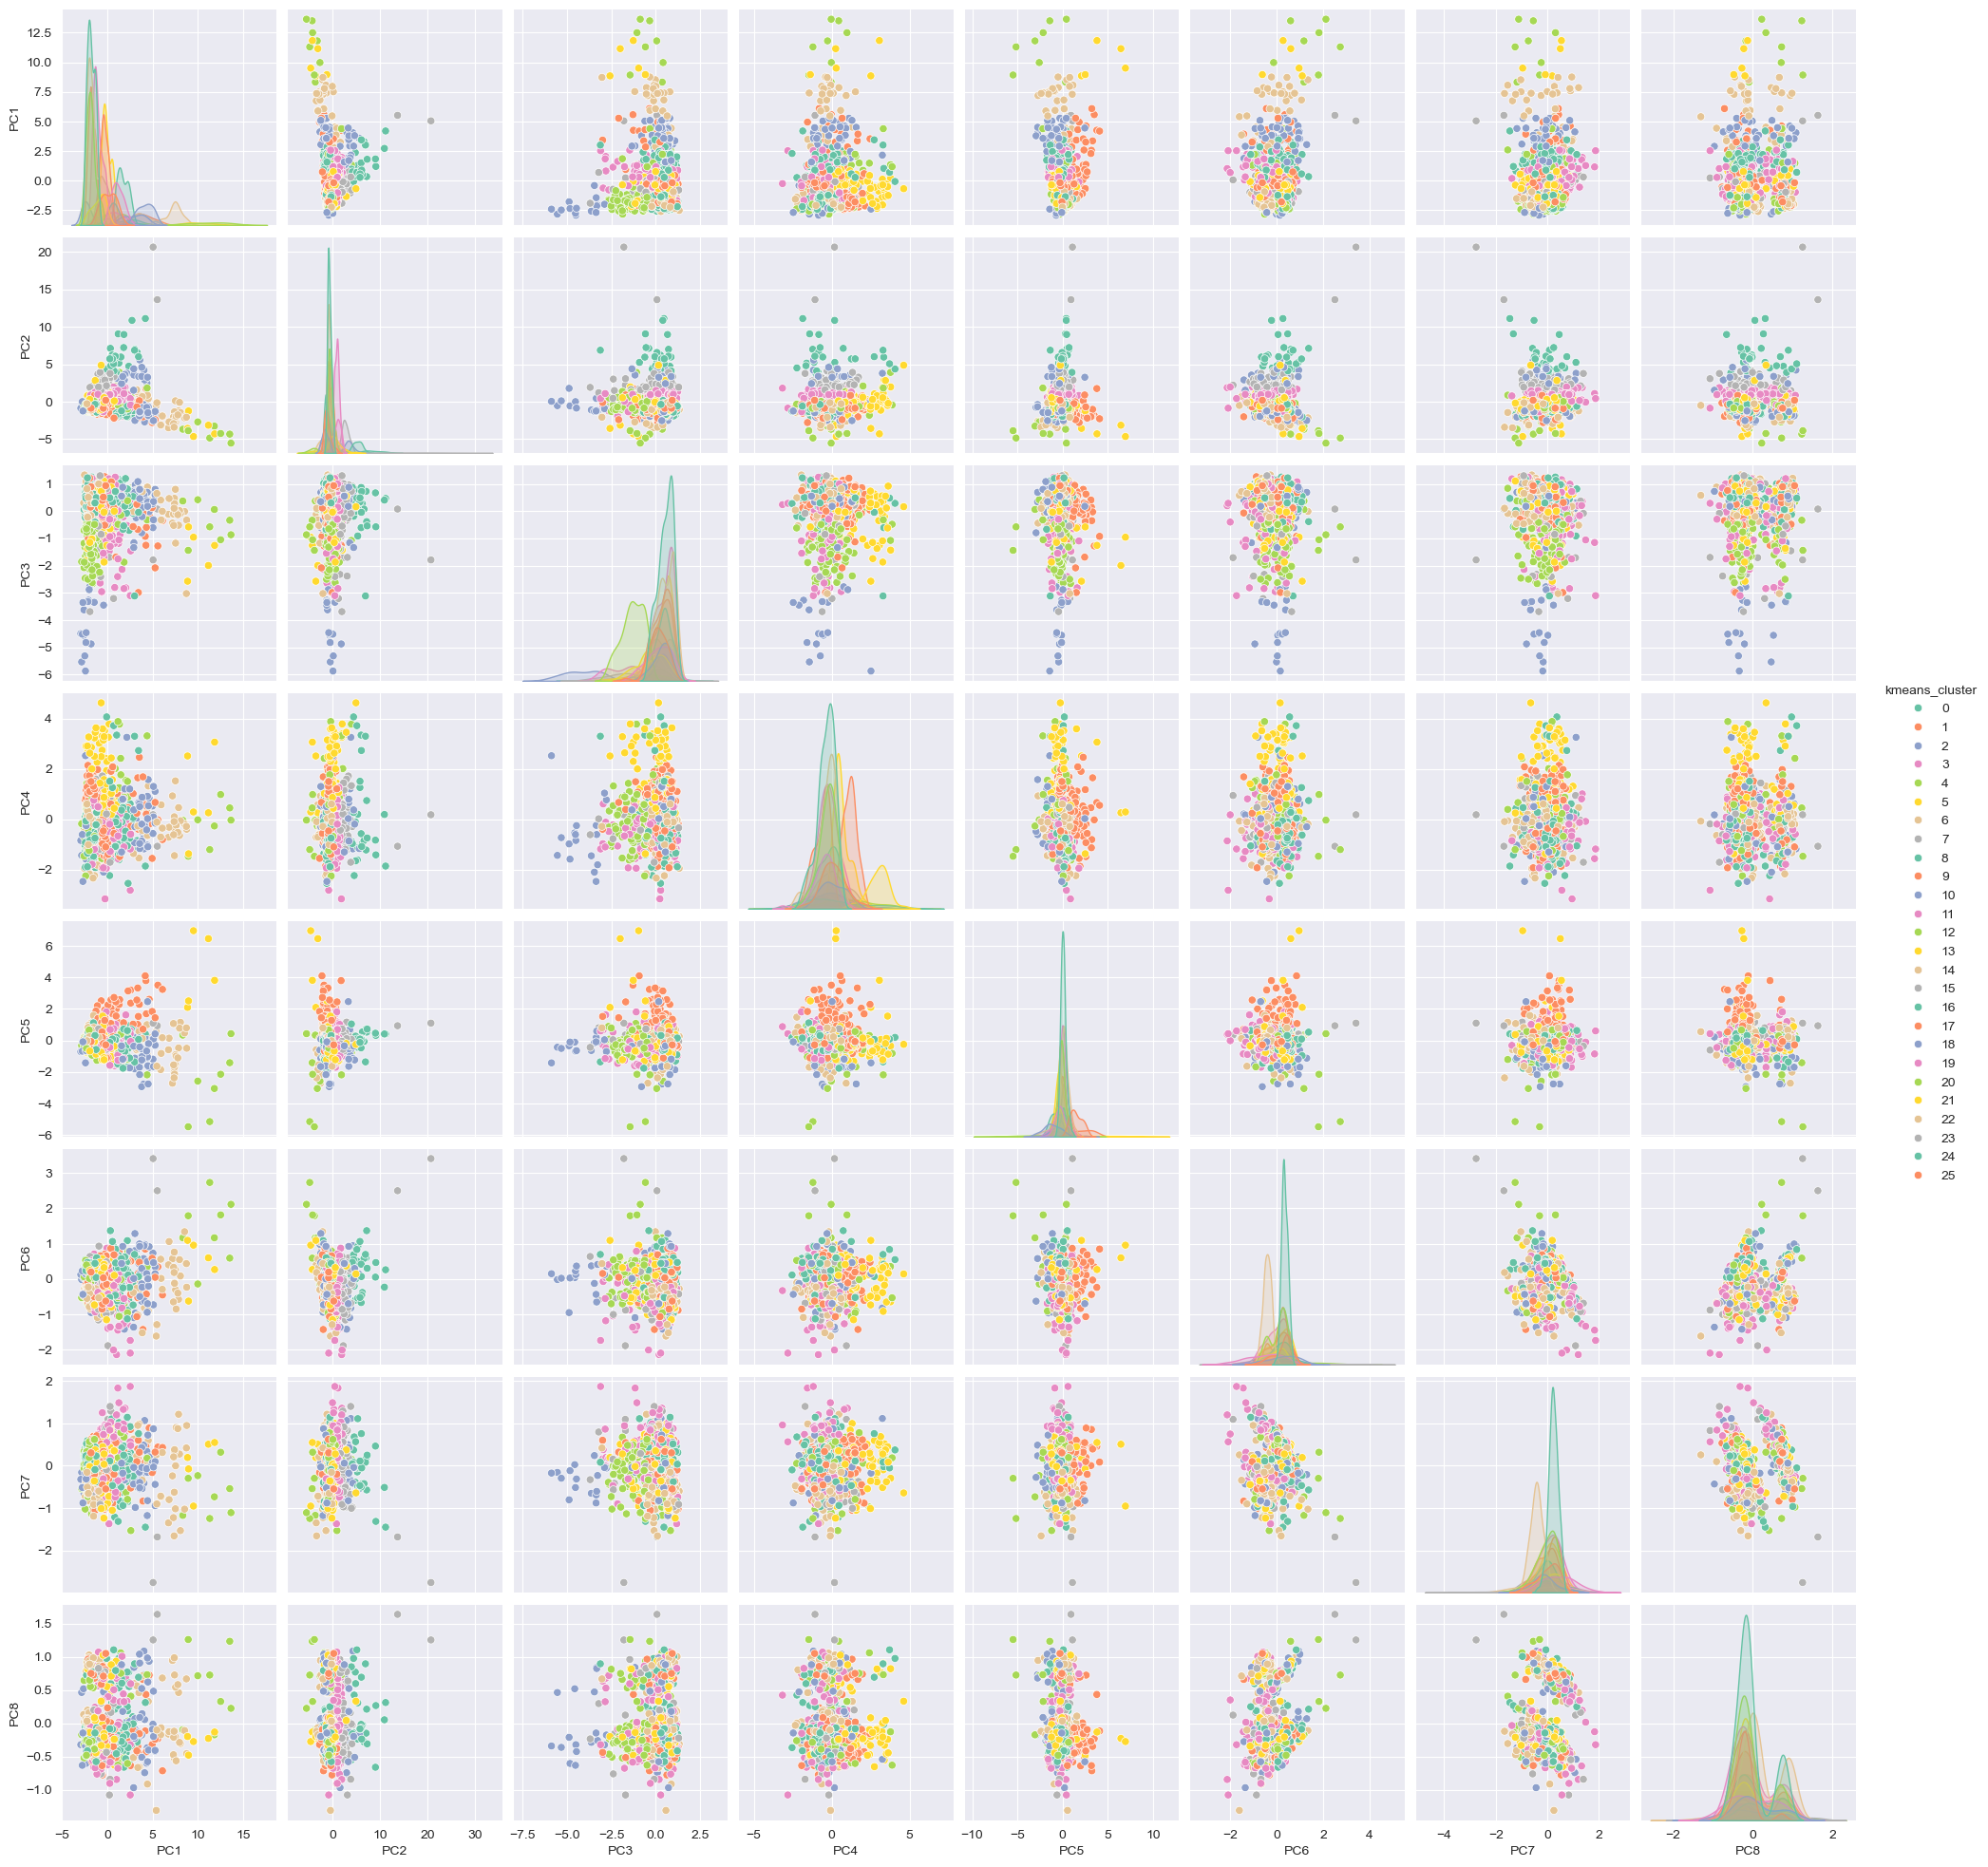

In [48]:
# How are clusters distinguished across different PC features
sns.pairplot(
    hue='kmeans_cluster',
    palette='Set2',
    data=users_df_kmeans_clusters.sample(
        n=1000,
        random_state=RANDOM_STATE
    )
)

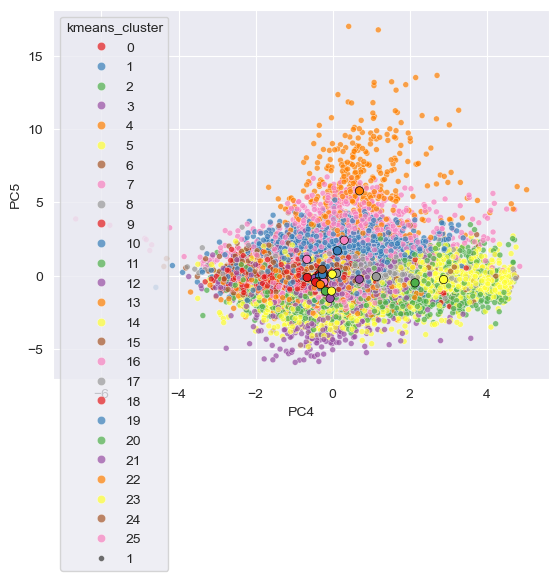

In [50]:
# Inspect a designated pc space more closely (look at pairplots for general overview)
# Also shows the centroids
variable_pairs = ['PC4', 'PC5']

#plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_kmeans_clusters.sample(
        n=100000,
        random_state=RANDOM_STATE
    )
)

sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    markers=1000,
    alpha=1,
    edgecolor="black",
    data=users_kmeans_centroids_df,
    legend=False
)
plt.show()

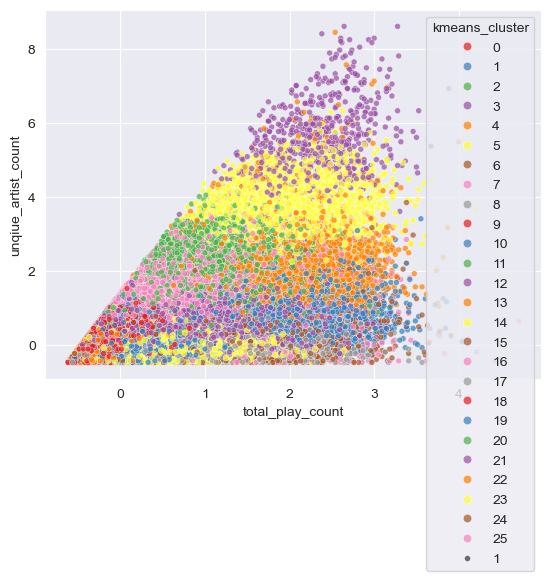

In [52]:
# To show that our current model is not separating just on play count and play time
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_clusters_orig.sample(n=100000, random_state=RANDOM_STATE)
)
plt.show()

## Model 2: HDBSCAN
Density based clustering

*   We noticed in a previous milestone that we had clusters with very few data points, so we wanted to try density based clustering to remedy this.
*   DBSCAN groups points that are closely packed together (many nearby neighbors)
*   Outliers in low-desnity regions are marked



Faizan's Colab (CPU with High RAM)

n= 100000

- x_map time: 1 minute
- hdbscan time: 93 sec


n= 200000
- x_map time: 130 sec
- hdbscan time:  458.84 seconds


n= 300000
- x_map time: 209.01 seconds
- hdbscan time:  1081.89 seconds

In [23]:
# hdbscan = O(n^2) = takes too long to run on full dataset
X_hdbscan = users_df.drop(columns=['user_id'])

In [24]:
print("Starting UMAP for HDBSCAN...")
start_time = time.time()
# works better than pca for hdbscan
X_umap = UMAP(
    n_components=15,
    n_neighbors=30,
    min_dist=0.0,
    # random_state=RANDOM_STATE
).fit_transform(X_hdbscan)

end_time = time.time()
print(f"UMAP completed in {end_time - start_time:.2f} seconds")

Starting HDBSCAN...
HDBSCAN completed in 28.41 seconds


In [26]:
print(X_umap.shape)

(100000, 15)


In [31]:
X_umap

array([[4.9247594, 4.850764 , 5.192082 , ..., 4.282797 , 4.3207803,
        5.1696324],
       [6.2098384, 3.9569917, 3.913656 , ..., 3.7583613, 5.1492996,
        5.3497286],
       [5.545323 , 4.58894  , 4.669534 , ..., 4.939647 , 2.815843 ,
        5.051488 ],
       ...,
       [5.9105053, 4.0346384, 4.3183026, ..., 4.8732643, 4.4174404,
        5.0309954],
       [4.4779806, 4.8747525, 5.6257396, ..., 4.5535283, 4.5002613,
        5.069576 ],
       [4.15718  , 3.6128519, 7.2468815, ..., 6.043325 , 5.5785904,
        3.9288244]], shape=(100000, 15), dtype=float32)

In [27]:
print("Starting HDBSCAN...")
start_time = time.time()

labels = HDBSCAN(
    min_cluster_size=20,  # start smaller in high-dim
    min_samples=10,  # controls how strict "core" points are
    # n_jobs=-1              # use all cores
).fit_predict(X_umap)

end_time = time.time()
print(f"HDBSCAN completed in {end_time - start_time:.2f} seconds")

Starting HDBSCAN...
HDBSCAN completed in 65.45 seconds


In [28]:
users_df["hdb_cluster"] = labels

In [29]:
users_df["hdb_cluster"].value_counts()

hdb_cluster
-1      35530
 100     8323
 128     6068
 44      2891
 83      2714
        ...  
 132       20
 108       20
 264       20
 117       20
 239       20
Name: count, Length: 394, dtype: int64

C:\Users\User\anaconda3\envs\music-recommender\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


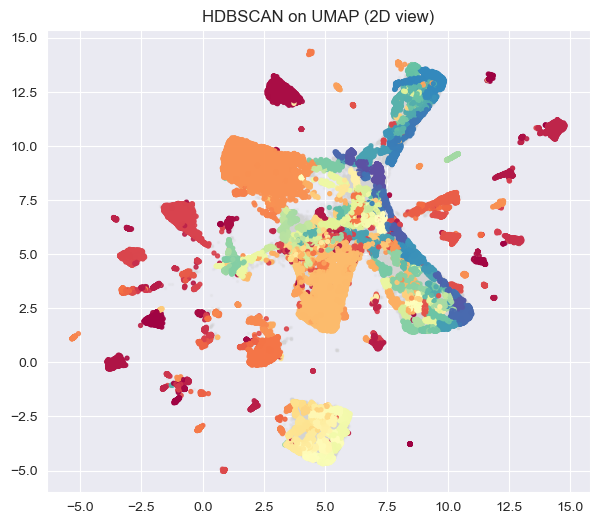

In [30]:
# ai slop
X_umap_2d = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
).fit_transform(X_hdbscan)
plot_df = pd.DataFrame(X_umap_2d, columns=["UMAP1", "UMAP2"])
plot_df["hdb_cluster"] = labels

noise = plot_df[plot_df["hdb_cluster"] == -1]
clusters = plot_df[plot_df["hdb_cluster"] != -1]

plt.figure(figsize=(7, 6))

# noise first, light gray
plt.scatter(
    noise["UMAP1"], noise["UMAP2"],
    c="lightgray", s=2, alpha=0.15
)

# clusters on top
plt.scatter(
    clusters["UMAP1"], clusters["UMAP2"],
    c=clusters["hdb_cluster"], cmap="Spectral",
    s=8, alpha=0.9
)

plt.title("HDBSCAN on UMAP (2D view)")
plt.show()

# Playlist Generation

In [ ]:
u_id = users_df_kmeans_clusters[users_df_kmeans_clusters['cluster_id'] == 8]['user_id'].values[0]
u_id

In [ ]:
songs_df[songs_df['user_id'] == u_id]

In [ ]:
users_df[users_df['user_id'] == u_id]


In [ ]:
users_df['total_play_time'].hist()

In [ ]:
users_songs_clusters = pd.merge(songs_df, users_df_kmeans_clusters, on='user_id')
users_songs_clusters = users_songs_clusters.drop(
    columns=["track_id", "artist_id", "artist_mbid", "shs_perf", "shs_work",
             "track_7digitalid", 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'])  #, 'PC6'])

In [ ]:
users_songs_clusters.head(5)

In [ ]:
# Group and sort in descending order
usc = users_songs_clusters.groupby(['cluster_id', 'song_id'])['plays'].count().sort_values(ascending=False)

In [ ]:
# Top 10 songs per cluster
top_10_per_cluster = usc.groupby(level='cluster_id').head(10)

In [ ]:
# Convert the top_10_per_cluster Series to a DataFrame
top_10_df = top_10_per_cluster.reset_index()
# Select relevant columns from users_songs_clusters
song_details_cols = ['cluster_id', 'song_id', 'title', 'release', 'artist_name', 'duration', 'artist_familiarity',
                     'artist_hotttnesss', 'tot_track_time']
users_songs_details = users_songs_clusters[song_details_cols]
# Merge with users_songs_details to get song details
top_songs_details = pd.merge(top_10_df, users_songs_details, on=['cluster_id', 'song_id'], how='left')
# Drop duplicate rows that might arise from the merge (keeping the first occurrence)
top_songs_details = top_songs_details.drop_duplicates(subset=['cluster_id', 'song_id'], keep='first')
# Display the resulting DataFrame
display(top_songs_details.head())

In [ ]:
users_songs_clusters['cluster_id'].value_counts()


In [ ]:
cluster_totals = users_songs_clusters.groupby('cluster_id').agg(
    total_plays=('plays', 'sum'),
    total_track_time=('tot_track_time', 'sum')
)

unique_users_per_cluster = users_df_kmeans_clusters.groupby('cluster_id')['user_id'].nunique()
unique_users_per_cluster = users_df_kmeans_clusters.groupby('cluster_id')['user_id'].nunique()

avg_plays_per_user = cluster_totals['total_plays'] / unique_users_per_cluster

avg_tot_track_time_per_user = cluster_totals['total_track_time'] / unique_users_per_cluster

cluster_summary_df = pd.DataFrame({
    'unique_users': unique_users_per_cluster,
    'total_plays': cluster_totals['total_plays'],
    'total_track_time': cluster_totals['total_track_time'],
    'avg_plays_per_user': avg_plays_per_user,
    'avg_total_track_time_per_user': avg_tot_track_time_per_user
})
display(cluster_summary_df)

In [ ]:
users

In [ ]:
cluster_summary_df_plot = cluster_summary_df.reset_index()
sns.pairplot(cluster_summary_df_plot, hue='cluster_id', palette='Set2', corner=True, diag_kind='kde')
plt.suptitle('Pairplot of Cluster Summary Metrics', y=1.02)
plt.show()